# 4.3 事後予測チェック

## インポート・設定

In [1]:
import dataclasses
import warnings
from numbers import Number

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
sns.set_theme()
warnings.simplefilter("ignore")
SEED = 0

観測データ

In [3]:
y_A = np.array([12, 9, 12, 14, 13, 13, 15, 8, 15, 6])

事後予測のためのデータセットを生成する。

In [4]:
@dataclasses.dataclass
class GammaDist:
    """ガンマ分布のパラメータを格納するクラス"""

    a: Number
    b: Number

    @property
    def rv(self):
        return stats.gamma(a=self.a, scale=1 / self.b)

    def sample(self, size) -> np.ndarray:
        return self.rv.rvs(size=size, random_state=SEED)


@dataclasses.dataclass
class PoissonDist:
    """ポアソン分布のパラメータを格納するクラス"""

    mu: Number

    @property
    def rv(self):
        return stats.poisson(self.mu)

    def sample(self, size) -> np.ndarray:
        return self.rv.rvs(size=size, random_state=SEED)

In [5]:
def generate_dataset(
    posterior_dist,
    n_samples,
    sample_size,
):

    # 事後分布からthetaをサンプリングする
    theta = posterior_dist.sample(size=n_samples)

    # 事後予測分布からデータyをサンプリングする
    dataset = PoissonDist(
        theta.reshape(n_samples, 1),
    ).sample(
        size=(n_samples, sample_size),
    )

    return type("DataSet", (), dict(theta=theta, dataset=dataset))

In [6]:
# 事後分布
posterior_A = GammaDist(a=237, b=20)
posterior_A

GammaDist(a=237, b=20)

In [7]:
# データセットを生成する
dataset_A = generate_dataset(posterior_A, n_samples=1000, sample_size=10)

# サンプルサイズ10のサンプルが1000個できた
print("thetaのサイズ:", dataset_A.theta.shape)
print("datasetのサイズ:", dataset_A.dataset.shape)

thetaのサイズ: (1000,)
datasetのサイズ: (1000, 10)


In [8]:
# thetaを5個見てみる
dataset_A.theta[:5]

array([13.24276562, 12.14381022, 13.32877017, 11.09741795, 11.75411496])

In [9]:
# 1個目のサンプルを見てみる
print("theta:\t", dataset_A.theta[0])
print("sample:\t", dataset_A.dataset[0])

theta:	 13.24276561619596
sample:	 [14 14 12 12 23 17  6 13  8 13]


## a

$t^{(s)}$ を計算する

In [10]:
def calculate_t(
    dataset: np.ndarray,
    y: np.ndarray,
):
    return_dict = {}

    # 各サンプルに対して、平均/標準偏差を計算してtを算出する
    t = dataset.mean(axis=1) / dataset.std(axis=1)
    return_dict["t"] = t

    # 観測データのt
    t_obs = y.mean() / y.std()
    return_dict["t_obs"] = t_obs

    # シミュレーションデータのtにおける観測データtの分位数
    quantile_t_obs = (t <= t_obs).sum() / len(t)
    return_dict["quantile_t_obs"] = quantile_t_obs

    return type("TStatistics", (), return_dict)

In [11]:
t_statistics_A = calculate_t(dataset=dataset_A.dataset, y=y_A)

In [12]:
# シミュレーションデータを5個みてみる
t_statistics_A.t[:5]

array([3.        , 4.37314282, 4.36132852, 3.66243195, 6.5       ])

In [13]:
# 観測データのt
t_statistics_A.t_obs

4.0344827586206895

In [14]:
# 観測値のtのシミュレーションデータに対する分位数
t_statistics_A.quantile_t_obs

0.621

シミュレーションデータのヒストグラムの上に観測データを描画する

In [15]:
def plot_t_statistics(
    t: np.ndarray,
    t_obs: float,
):
    quantile_t_obs = (t <= t_obs).sum() / len(t)

    sns.displot(
        x=t,
        aspect=1.5,
    ).set(xlabel="t", title=r"Histgram of $t^{(s)}$")
    plt.vlines(
        t_obs,
        *plt.gca().get_ylim(),
        colors="r",
        label="$t_{obs}$" f" (quantile = {quantile_t_obs})",
    )
    plt.legend()

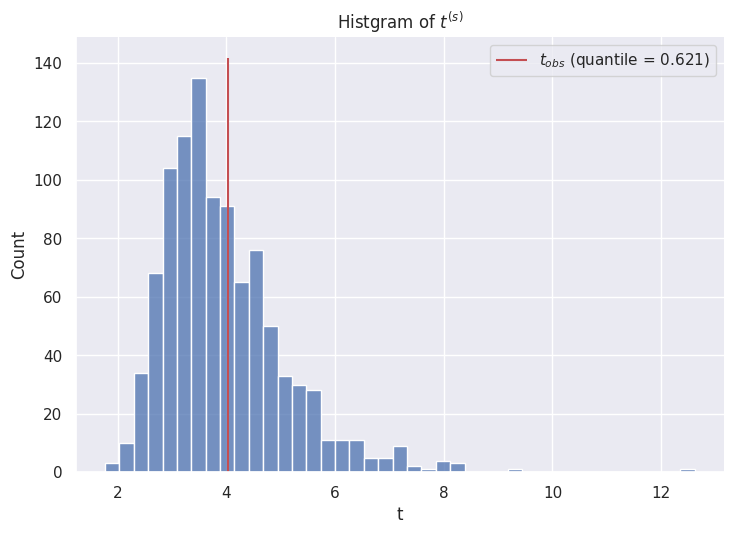

In [16]:
plot_t_statistics(
    t=t_statistics_A.t,
    t_obs=t_statistics_A.t_obs,
)

以上より、観測値から計算した $t$ はシミュレーションデータの最頻値付近にあり、シミュレーションデータの62.1%点にあることがわかった。
よって、ポアソンモデルはこの統計量 $t$ の分布をよく表現できていると考えられるため、ポアソンモデルは妥当だといえる。

## b

群Bに対しても同様の検証を行う

In [30]:
y_B = np.array([11, 11, 10, 9, 9, 8, 7, 10, 6, 8, 8, 9, 7])

In [24]:
# 事後分布
posterior_B = GammaDist(a=125, b=14)
posterior_B

GammaDist(a=125, b=14)

In [25]:
# データセットを生成する
dataset_B = generate_dataset(posterior_B, n_samples=1000, sample_size=10)

# サンプルサイズ10のサンプルが1000個できた
print("thetaのサイズ:", dataset_B.theta.shape)
print("datasetのサイズ:", dataset_B.dataset.shape)

thetaのサイズ: (1000,)
datasetのサイズ: (1000, 10)


In [26]:
# thetaを5個見てみる
dataset_B.theta[:5]

array([10.38704   ,  9.22772706, 10.47878133,  8.14787194,  8.82269516])

In [27]:
# 1個目のサンプルを見てみる
print("theta:\t", dataset_B.theta[0])
print("sample:\t", dataset_B.dataset[0])

theta:	 10.387039995152556
sample:	 [11 11 10 10 19 13  4 10  6 11]


In [31]:
t_statistics_B = calculate_t(dataset=dataset_B.dataset, y=y_B)

In [32]:
# シミュレーションデータを5個みてみる
t_statistics_B.t[:5]

array([2.78151795, 3.38461538, 4.1576092 , 3.52821143, 2.88659718])

In [33]:
# 観測データのt
t_statistics_B.t_obs

5.843090896943715

In [34]:
# 観測値のtのシミュレーションデータに対する分位数
t_statistics_B.quantile_t_obs

0.981

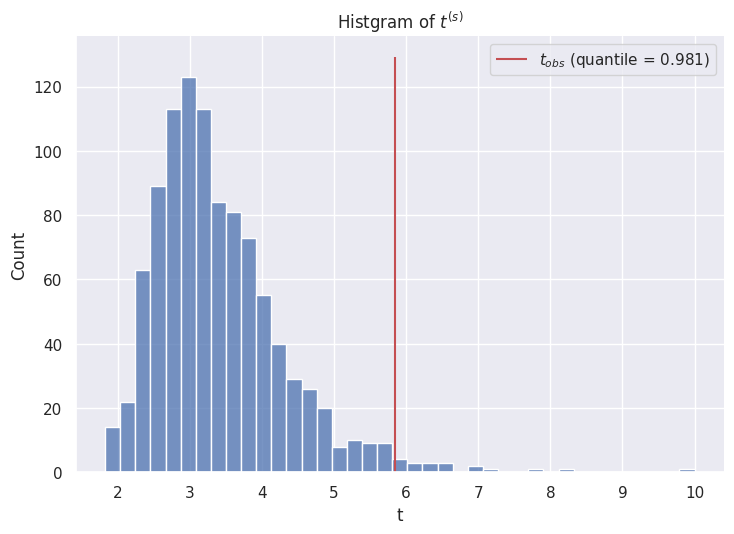

In [35]:
plot_t_statistics(
    t=t_statistics_B.t,
    t_obs=t_statistics_B.t_obs,
)

以上より、群Bについては観測値から計算した $t$ はシミュレーションデータの98.1%点にあることがわかった。
よって、ポアソンモデルはこの統計量 $t$ の分布をうまく表しているとは考えられず、 $t$ についての推測を行うためには別のモデルを使用するべきだろう。